In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import random 
from tqdm import tqdm
from data_utils.load_cora import *
from data_utils.load_pubmed import *

import torch.nn.functional as F
from torch_geometric.nn import GCNConv

from sklearn.model_selection import ParameterGrid

/home/kshou/miniconda3/envs/gnn/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def set_seed(seed=0):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
    np.random.seed(seed)  
    random.seed(seed)

set_seed(0)

In [3]:
# train one epoch
def train(model, data, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def evaluate(model, data, eval_split='test'):
    assert eval_split in ['train', 'val', 'test']
    model.eval()
    with torch.no_grad():
        logits = model(data)
        preds = logits.argmax(dim=1)
        mask = data[f'{eval_split}_mask']       # 'train_mask', 'val_mask', 'test_mask'
        correct = (preds[mask] == data.y[mask]).sum()
        acc = int(correct) / int(mask.sum())
    return acc

def train_and_eval_once(model, data, optimizer, criterion, epochs=200, early_stop_ep=50, \
                        val_ep=1, mute=False):
    assert val_ep < early_stop_ep
    
    # eval before training on all three sets
    acc_train = evaluate(model, data, eval_split='train')
    acc_val = evaluate(model, data, eval_split='val')
    acc_test = evaluate(model, data, eval_split='test')
    if not mute:
        print(f'Accuracy before training: Train: {acc_train*100:.2f}%, Val: {acc_val*100:.2f}%, Test: {acc_test*100:.2f}%')

    # train
    epochs_no_improve = 0
    best_acc_val = 0.
    for i in tqdm(range(epochs)):
        epoch = i + 1
        loss = train(model, data, optimizer, criterion)

        # validation every val_ep epochs
        if epoch % val_ep == 0:
            acc_val = evaluate(model, data, eval_split='val')
            # if not mute:
            #     print(f'Epoch {epoch}, Loss: {loss:.4f}, Val Acc: {acc_val*100:.2f}%')
            
            if acc_val > best_acc_val:
                best_acc_val = acc_val
                epochs_no_improve = 0
            else:
                epochs_no_improve += val_ep

            if epochs_no_improve >= early_stop_ep:
                print(f'Early stopping at epoch {epoch}')
                break

    
    # eval after training on all three sets
    acc_train = evaluate(model, data, eval_split='train')
    acc_val = evaluate(model, data, eval_split='val')
    acc_test = evaluate(model, data, eval_split='test')
    if not mute:
        print(f'Accuracy after training: Train: {acc_train*100:.2f}%, Val: {acc_val*100:.2f}%, Test: {acc_test*100:.2f}%')
    
    acc_dict = {'train': acc_train, 'val': acc_val, 'test': acc_test}
    return acc_dict


In [4]:
class GCN(torch.nn.Module):
    def __init__(self, in_dim, hid_dim, num_classes, num_layers=2):
        super().__init__()
        assert num_layers >= 2
        self.conv_layers = nn.ModuleList()
        self.conv_layers.append(GCNConv(in_dim, hid_dim, cached=True))       # first layer
        
        for _ in range(num_layers - 2):
            self.conv_layers.append(GCNConv(hid_dim, hid_dim, cached=True))  # hidden layers
        
        self.conv_layers.append(GCNConv(hid_dim, num_classes, cached=True))   # last layer

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        for i, conv in enumerate(self.conv_layers[:-1]):
            x = conv(x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=0.5, training=self.training)

        x = self.conv_layers[-1](x, edge_index)     # logit,    [N, num_classes]
        return x            

In [5]:
from transformers import BertTokenizer, BertModel

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', max_position_embeddings=512)
model_text = BertModel.from_pretrained('bert-base-uncased', max_position_embeddings=512)
# print(model)
model_text.pooler = nn.Identity()
# print(model)
model_text = model_text.cuda()
model_text.eval()

/home/kshou/miniconda3/envs/gnn/lib/python3.11/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/home/kshou/miniconda3/envs/gnn/lib/python3.11/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any fe

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

### Cora

In [6]:
# load Cora
data_cora, text_cora = get_raw_text_cora(use_text=True)
data_cora.num_classes = data_cora.y.max().item() + 1      # 7

In [7]:
# get text embeddings for all nodes
node_text_embed = torch.zeros(data_cora.num_nodes, 768).cuda()     # [N, 768]

bs = 512
with torch.no_grad():
    for i in range(0, data_cora.num_nodes, bs):
        text_inputs = tokenizer(text_cora[i:i+bs], padding=True, truncation=True, return_tensors='pt')
        text_inputs.to('cuda')
        outputs = model_text(**text_inputs)
        last_hidden_states = outputs.last_hidden_state          # [bs, 512, 768]
        node_text_embed[i:i+bs] = last_hidden_states[:, 0, :]   # use cls token's embedding

In [8]:
# replace node features with text embeddings
data_cora.x = node_text_embed

In [9]:
EPOCHS = 500
param_grid = {                      # 120 sets in total
    'lr': [1e-4, 1e-3, 0.01, 0.1],
    'hid_dim': [16, 32, 64, 128, 256, 512],
    'n_layers': [2, 3, 4, 5, 10]
}
param_comb = list(ParameterGrid(param_grid))
val_acc_best = 0.

data_cora = data_cora.cuda()
for c in param_comb:
    set_seed(0)
    lr = c['lr']
    hid_dim = c['hid_dim']
    n_layers = c['n_layers']

    model_gnn = GCN(data_cora.x.shape[1], hid_dim, data_cora.num_classes, num_layers=n_layers)
    optimizer = torch.optim.Adam(model_gnn.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    model_gnn = model_gnn.cuda()

    acc_dict = train_and_eval_once(model_gnn, data_cora, optimizer, criterion, epochs=EPOCHS, mute=True)
    if acc_dict['val'] > val_acc_best:
        val_acc_best = acc_dict['val']
        best_param = c
        train_acc_best = acc_dict['train']
        test_acc_best = acc_dict['test']

print(f'Best param: {best_param}, Best Val Acc: {val_acc_best*100:.2f}%')
print(f'With: Train Acc: {train_acc_best*100:.2f}%, Test Acc: {test_acc_best*100:.2f}%')

 13%|█▎        | 63/500 [00:00<00:01, 280.83it/s]


Early stopping at epoch 64


 92%|█████████▏| 461/500 [00:02<00:00, 184.53it/s]


Early stopping at epoch 462


 13%|█▎        | 63/500 [00:00<00:04, 93.47it/s] 


Early stopping at epoch 64


 14%|█▍        | 70/500 [00:00<00:02, 164.10it/s]


Early stopping at epoch 71


 11%|█▏        | 57/500 [00:00<00:04, 96.11it/s] 


Early stopping at epoch 58


 78%|███████▊  | 391/500 [00:01<00:00, 291.42it/s]


Early stopping at epoch 392


 67%|██████▋   | 337/500 [00:01<00:00, 225.95it/s]


Early stopping at epoch 338


 11%|█         | 53/500 [00:00<00:02, 180.01it/s]


Early stopping at epoch 54


 10%|█         | 51/500 [00:00<00:03, 116.13it/s]


Early stopping at epoch 52


 11%|█         | 56/500 [00:00<00:01, 400.14it/s]


Early stopping at epoch 57


 11%|█         | 53/500 [00:00<00:01, 245.40it/s]


Early stopping at epoch 54


 10%|█         | 50/500 [00:00<00:01, 225.92it/s]


Early stopping at epoch 51


 10%|█         | 50/500 [00:00<00:02, 200.95it/s]


Early stopping at epoch 51


 10%|█         | 50/500 [00:00<00:04, 107.99it/s]


Early stopping at epoch 51


 12%|█▏        | 61/500 [00:00<00:02, 214.25it/s]


Early stopping at epoch 62


 12%|█▏        | 60/500 [00:00<00:02, 191.39it/s]


Early stopping at epoch 61


 16%|█▌        | 80/500 [00:00<00:03, 106.64it/s]


Early stopping at epoch 81


 72%|███████▏  | 362/500 [00:01<00:00, 301.62it/s]


Early stopping at epoch 363


 74%|███████▍  | 370/500 [00:01<00:00, 242.06it/s]


Early stopping at epoch 371


 56%|█████▌    | 278/500 [00:01<00:01, 209.66it/s]


Early stopping at epoch 279


 82%|████████▏ | 409/500 [00:02<00:00, 188.50it/s]


Early stopping at epoch 410


 10%|█         | 51/500 [00:00<00:04, 103.10it/s]


Early stopping at epoch 52


 38%|███▊      | 189/500 [00:00<00:01, 267.07it/s]


Early stopping at epoch 190


 58%|█████▊    | 291/500 [00:01<00:01, 200.07it/s]


Early stopping at epoch 292


 59%|█████▉    | 296/500 [00:01<00:01, 160.79it/s]


Early stopping at epoch 297


 95%|█████████▌| 475/500 [00:04<00:00, 115.24it/s]


Early stopping at epoch 476


 10%|█         | 52/500 [00:00<00:01, 367.82it/s]


Early stopping at epoch 53


 21%|██        | 105/500 [00:00<00:01, 303.92it/s]


Early stopping at epoch 106


 10%|█         | 50/500 [00:00<00:01, 241.98it/s]


Early stopping at epoch 51


 10%|█         | 50/500 [00:00<00:02, 175.98it/s]


Early stopping at epoch 51


 10%|█         | 50/500 [00:00<00:04, 98.36it/s] 


Early stopping at epoch 51


 12%|█▏        | 59/500 [00:00<00:01, 253.54it/s]


Early stopping at epoch 60


 13%|█▎        | 67/500 [00:00<00:02, 188.24it/s]


Early stopping at epoch 68


 16%|█▋        | 82/500 [00:00<00:02, 165.89it/s]


Early stopping at epoch 83


 12%|█▏        | 61/500 [00:00<00:04, 104.98it/s]


Early stopping at epoch 62


 55%|█████▌    | 276/500 [00:00<00:00, 360.22it/s]


Early stopping at epoch 277


 60%|██████    | 300/500 [00:01<00:00, 229.44it/s]


Early stopping at epoch 301


 55%|█████▍    | 274/500 [00:01<00:01, 164.33it/s]


Early stopping at epoch 275


 59%|█████▉    | 295/500 [00:01<00:01, 152.95it/s]


Early stopping at epoch 296


 85%|████████▍ | 424/500 [00:03<00:00, 107.90it/s]


Early stopping at epoch 425


 53%|█████▎    | 264/500 [00:00<00:00, 335.57it/s]


Early stopping at epoch 265


 45%|████▍     | 223/500 [00:00<00:01, 252.15it/s]


Early stopping at epoch 224


 44%|████▍     | 219/500 [00:00<00:01, 258.76it/s]


Early stopping at epoch 220


 54%|█████▍    | 271/500 [00:01<00:01, 176.22it/s]


Early stopping at epoch 272


 10%|█         | 50/500 [00:00<00:03, 129.23it/s]


Early stopping at epoch 51


 10%|█         | 50/500 [00:00<00:01, 380.88it/s]


Early stopping at epoch 51


 10%|█         | 50/500 [00:00<00:01, 291.19it/s]

Early stopping at epoch 51



 10%|█         | 50/500 [00:00<00:01, 226.34it/s]


Early stopping at epoch 51


 10%|█         | 50/500 [00:00<00:02, 161.22it/s]


Early stopping at epoch 51


 10%|█         | 50/500 [00:00<00:03, 131.16it/s]


Early stopping at epoch 51


 86%|████████▌ | 428/500 [00:01<00:00, 356.38it/s]


Early stopping at epoch 429


 96%|█████████▌| 481/500 [00:01<00:00, 276.12it/s]


Early stopping at epoch 482


 92%|█████████▏| 462/500 [00:02<00:00, 217.25it/s]


Early stopping at epoch 463


 11%|█         | 55/500 [00:00<00:02, 167.85it/s]


Early stopping at epoch 56


 11%|█         | 54/500 [00:00<00:04, 97.46it/s] 


Early stopping at epoch 55


 49%|████▉     | 246/500 [00:00<00:00, 330.03it/s]


Early stopping at epoch 247


 35%|███▍      | 173/500 [00:00<00:01, 263.84it/s]


Early stopping at epoch 174


 36%|███▋      | 182/500 [00:00<00:01, 216.26it/s]


Early stopping at epoch 183


 53%|█████▎    | 265/500 [00:01<00:01, 179.55it/s]


Early stopping at epoch 266


 69%|██████▊   | 343/500 [00:03<00:01, 106.84it/s]


Early stopping at epoch 344


 68%|██████▊   | 338/500 [00:01<00:00, 332.18it/s]


Early stopping at epoch 339


 36%|███▌      | 180/500 [00:00<00:01, 271.25it/s]


Early stopping at epoch 181


 40%|████      | 202/500 [00:00<00:01, 216.68it/s]


Early stopping at epoch 203


 42%|████▏     | 208/500 [00:01<00:01, 206.31it/s]


Early stopping at epoch 209


 10%|█         | 50/500 [00:00<00:04, 93.32it/s]


Early stopping at epoch 51


 11%|█         | 55/500 [00:00<00:01, 288.35it/s]


Early stopping at epoch 56


 22%|██▏       | 112/500 [00:00<00:01, 239.02it/s]


Early stopping at epoch 113


 10%|█         | 50/500 [00:00<00:02, 179.38it/s]


Early stopping at epoch 51


 10%|█         | 50/500 [00:00<00:02, 163.58it/s]


Early stopping at epoch 51


 10%|█         | 50/500 [00:00<00:04, 96.53it/s] 


Early stopping at epoch 51


 81%|████████▏ | 407/500 [00:01<00:00, 357.18it/s]


Early stopping at epoch 408


 71%|███████   | 354/500 [00:01<00:00, 285.03it/s]


Early stopping at epoch 355


 65%|██████▍   | 323/500 [00:01<00:00, 220.83it/s]


Early stopping at epoch 324


 83%|████████▎ | 416/500 [00:02<00:00, 180.49it/s]


Early stopping at epoch 417


 10%|█         | 50/500 [00:00<00:04, 95.38it/s] 


Early stopping at epoch 51


 47%|████▋     | 234/500 [00:00<00:00, 307.47it/s]


Early stopping at epoch 235


 32%|███▏      | 162/500 [00:00<00:01, 218.53it/s]


Early stopping at epoch 163


 38%|███▊      | 188/500 [00:00<00:01, 210.58it/s]


Early stopping at epoch 189


 30%|███       | 152/500 [00:00<00:02, 162.01it/s]


Early stopping at epoch 153


 50%|█████     | 250/500 [00:02<00:02, 112.53it/s]


Early stopping at epoch 251


 55%|█████▍    | 274/500 [00:00<00:00, 324.35it/s]


Early stopping at epoch 275


 43%|████▎     | 216/500 [00:00<00:01, 283.87it/s]


Early stopping at epoch 217


 45%|████▍     | 224/500 [00:01<00:01, 212.54it/s]


Early stopping at epoch 225


 87%|████████▋ | 435/500 [00:02<00:00, 194.28it/s]


Early stopping at epoch 436


 10%|█         | 50/500 [00:00<00:04, 104.61it/s]


Early stopping at epoch 51


 10%|█         | 50/500 [00:00<00:01, 324.71it/s]

Early stopping at epoch 51



 10%|█         | 50/500 [00:00<00:01, 311.75it/s]

Early stopping at epoch 51



 14%|█▍        | 72/500 [00:00<00:01, 257.50it/s]


Early stopping at epoch 73


 10%|█         | 50/500 [00:00<00:02, 183.56it/s]


Early stopping at epoch 51


 10%|█         | 50/500 [00:00<00:04, 102.13it/s]


Early stopping at epoch 51


 50%|█████     | 250/500 [00:00<00:00, 350.48it/s]


Early stopping at epoch 251


 74%|███████▍  | 370/500 [00:01<00:00, 234.63it/s]


Early stopping at epoch 371


 57%|█████▋    | 286/500 [00:01<00:01, 185.85it/s]


Early stopping at epoch 287


 66%|██████▌   | 329/500 [00:02<00:01, 142.43it/s]


Early stopping at epoch 330


 67%|██████▋   | 337/500 [00:04<00:02, 72.79it/s]


Early stopping at epoch 338


 51%|█████     | 254/500 [00:00<00:00, 351.11it/s]


Early stopping at epoch 255


 31%|███       | 154/500 [00:00<00:01, 237.61it/s]


Early stopping at epoch 155


 37%|███▋      | 185/500 [00:01<00:01, 179.61it/s]


Early stopping at epoch 186


 33%|███▎      | 163/500 [00:01<00:02, 145.33it/s]


Early stopping at epoch 164


 67%|██████▋   | 336/500 [00:04<00:02, 72.21it/s]


Early stopping at epoch 337


 39%|███▉      | 196/500 [00:00<00:00, 350.70it/s]


Early stopping at epoch 197


 32%|███▏      | 158/500 [00:00<00:01, 229.39it/s]


Early stopping at epoch 159


 64%|██████▍   | 320/500 [00:01<00:01, 179.99it/s]


Early stopping at epoch 321


 10%|█         | 50/500 [00:00<00:03, 142.92it/s]


Early stopping at epoch 51


 10%|█         | 50/500 [00:00<00:06, 71.92it/s]


Early stopping at epoch 51


 10%|█         | 50/500 [00:00<00:01, 330.09it/s]

Early stopping at epoch 51



 21%|██        | 105/500 [00:00<00:01, 249.66it/s]


Early stopping at epoch 106


 10%|█         | 50/500 [00:00<00:02, 176.06it/s]


Early stopping at epoch 51


 10%|█         | 50/500 [00:00<00:03, 144.32it/s]


Early stopping at epoch 51


 10%|█         | 50/500 [00:00<00:06, 69.71it/s]

Early stopping at epoch 51
Best param: {'hid_dim': 64, 'lr': 0.001, 'n_layers': 3}, Best Val Acc: 87.08%
With: Train Acc: 91.26%, Test Acc: 86.53%


Number of layers: 2


 55%|█████▌    | 276/500 [00:01<00:00, 249.99it/s]


Early stopping at epoch 277
Number of layers: 3


 60%|██████    | 300/500 [00:02<00:01, 148.42it/s]


Early stopping at epoch 301
Number of layers: 4


 55%|█████▍    | 274/500 [00:01<00:01, 146.49it/s]


Early stopping at epoch 275
Number of layers: 5


 59%|█████▉    | 294/500 [00:02<00:01, 126.39it/s]


Early stopping at epoch 295
Number of layers: 10


 80%|████████  | 400/500 [00:06<00:01, 66.29it/s]


Early stopping at epoch 401


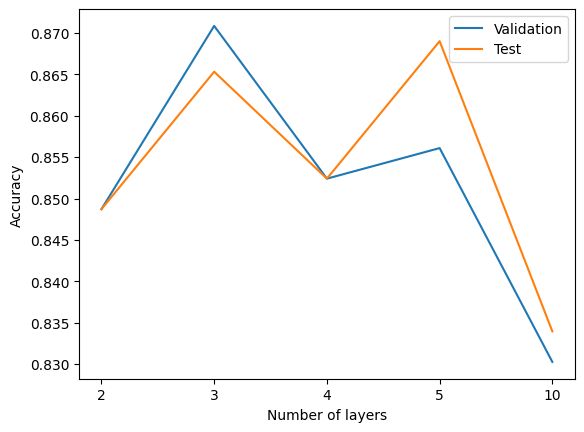

acc val: [0.8487084870848709, 0.8708487084870848, 0.8523985239852399, 0.8560885608856088, 0.8302583025830258]
acc test: [0.8487084870848709, 0.8653136531365314, 0.8523985239852399, 0.8690036900369004, 0.8339483394833949]


In [10]:
hid_dim = 64
epochs = 500
lr = 0.001
n_layers_search = [2, 3, 4, 5, 10]

acc_val_list = []
acc_test_list = []
data_cora = data_cora.cuda()
for n_layers in n_layers_search:
    set_seed(0)
    model = GCN(data_cora.x.shape[1], hid_dim, data_cora.num_classes, num_layers=n_layers)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model = model.cuda()
    print(f'Number of layers: {n_layers}')
    acc_dict = train_and_eval_once(model, data_cora, optimizer, nn.CrossEntropyLoss(), epochs=epochs, mute=True)
    acc_val_list.append(acc_dict['val'])
    acc_test_list.append(acc_dict['test'])

# plot
plt.plot([str(d) for d in n_layers_search], acc_val_list, label='Validation')
plt.plot([str(d) for d in n_layers_search], acc_test_list, label='Test')
plt.xlabel('Number of layers')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

print(f"acc val: {acc_val_list}")
print(f"acc test: {acc_test_list}")

### PubMed

In [12]:
# load Pubmed
data_pubmed, text_pubmed = get_raw_text_pubmed(use_text=True)
data_pubmed.num_classes = data_pubmed.y.max().item() + 1      # 3

In [13]:
# get text embeddings for all nodes
node_text_embed = torch.zeros(data_pubmed.num_nodes, 768).cuda()     # [N, 768]

bs = 512
with torch.no_grad():
    for i in tqdm(range(0, data_pubmed.num_nodes, bs)):
        text_inputs = tokenizer(text_pubmed[i:i+bs], padding=True, truncation=True, return_tensors='pt')
        text_inputs.to('cuda')
        outputs = model_text(**text_inputs)
        last_hidden_states = outputs.last_hidden_state          # [bs, 512, 768]
        node_text_embed[i:i+bs] = last_hidden_states[:, 0, :]   # use cls token's embedding

100%|██████████| 39/39 [02:27<00:00,  3.78s/it]


In [14]:
# replace node features with text embeddings
data_pubmed.x = node_text_embed

In [13]:
EPOCHS = 500
param_grid = {                      # 120 sets in total
    'lr': [1e-4, 1e-3, 0.01, 0.1],
    'hid_dim': [16, 32, 64, 128, 256, 512],
    'n_layers': [2, 3, 4, 5, 10]
}
param_comb = list(ParameterGrid(param_grid))
val_acc_best = 0.

data_pubmed = data_pubmed.cuda()
for c in param_comb:
    set_seed(0)
    lr = c['lr']
    hid_dim = c['hid_dim']
    n_layers = c['n_layers']

    model_gnn = GCN(data_pubmed.x.shape[1], hid_dim, data_pubmed.num_classes, num_layers=n_layers)
    optimizer = torch.optim.Adam(model_gnn.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    model_gnn = model_gnn.cuda()

    acc_dict = train_and_eval_once(model_gnn, data_pubmed, optimizer, criterion, epochs=EPOCHS, mute=True)
    if acc_dict['val'] > val_acc_best:
        val_acc_best = acc_dict['val']
        best_param = c
        train_acc_best = acc_dict['train']
        test_acc_best = acc_dict['test']

print(f'Best param: {best_param}, Best Val Acc: {val_acc_best*100:.2f}%')
print(f'With: Train Acc: {train_acc_best*100:.2f}%, Test Acc: {test_acc_best*100:.2f}%')

 10%|█         | 50/500 [00:00<00:04, 102.75it/s]


Early stopping at epoch 51


 91%|█████████ | 455/500 [00:01<00:00, 290.24it/s]


Early stopping at epoch 456


 12%|█▏        | 59/500 [00:00<00:01, 337.25it/s]


Early stopping at epoch 60


 68%|██████▊   | 339/500 [00:01<00:00, 260.99it/s]


Early stopping at epoch 340


 69%|██████▊   | 343/500 [00:01<00:00, 213.51it/s]


Early stopping at epoch 344


 10%|█         | 51/500 [00:00<00:03, 116.21it/s]


Early stopping at epoch 52


 10%|█         | 50/500 [00:00<00:01, 348.04it/s]


Early stopping at epoch 51


 10%|█         | 50/500 [00:00<00:01, 288.21it/s]

Early stopping at epoch 51



 10%|█         | 51/500 [00:00<00:01, 226.34it/s]


Early stopping at epoch 52


 10%|█         | 51/500 [00:00<00:02, 208.94it/s]


Early stopping at epoch 52


 10%|█         | 51/500 [00:00<00:04, 93.51it/s] 


Early stopping at epoch 52


 16%|█▋        | 82/500 [00:00<00:02, 174.37it/s]


Early stopping at epoch 83


 12%|█▏        | 60/500 [00:00<00:04, 99.63it/s] 


Early stopping at epoch 61


 86%|████████▌ | 428/500 [00:01<00:00, 235.18it/s]


Early stopping at epoch 429


 65%|██████▍   | 323/500 [00:02<00:01, 152.85it/s]


Early stopping at epoch 324


 69%|██████▉   | 346/500 [00:03<00:01, 92.43it/s] 


Early stopping at epoch 347


 68%|██████▊   | 339/500 [00:01<00:00, 248.98it/s]


Early stopping at epoch 340


 89%|████████▉ | 447/500 [00:02<00:00, 213.02it/s]


Early stopping at epoch 448


 71%|███████   | 356/500 [00:01<00:00, 178.45it/s]


Early stopping at epoch 357


 82%|████████▏ | 411/500 [00:03<00:00, 107.30it/s]


Early stopping at epoch 412


 11%|█         | 53/500 [00:00<00:01, 315.93it/s]

Early stopping at epoch 54



 10%|█         | 52/500 [00:00<00:01, 266.78it/s]


Early stopping at epoch 53


 11%|█         | 53/500 [00:00<00:01, 224.77it/s]


Early stopping at epoch 54


 10%|█         | 50/500 [00:00<00:02, 199.19it/s]


Early stopping at epoch 51


 10%|█         | 51/500 [00:00<00:04, 107.48it/s]


Early stopping at epoch 52


 72%|███████▏  | 361/500 [00:02<00:00, 179.69it/s]


Early stopping at epoch 362


 75%|███████▌  | 375/500 [00:02<00:00, 159.60it/s]


Early stopping at epoch 376


 80%|████████  | 400/500 [00:04<00:01, 86.47it/s]


Early stopping at epoch 401


 91%|█████████▏| 457/500 [00:01<00:00, 315.83it/s]


Early stopping at epoch 458


 68%|██████▊   | 340/500 [00:01<00:00, 238.52it/s]


Early stopping at epoch 341


 50%|████▉     | 249/500 [00:01<00:01, 190.90it/s]


Early stopping at epoch 250


 85%|████████▌ | 427/500 [00:02<00:00, 154.19it/s]


Early stopping at epoch 428


 80%|████████  | 402/500 [00:04<00:01, 86.14it/s]


Early stopping at epoch 403


 10%|█         | 50/500 [00:00<00:01, 364.67it/s]


Early stopping at epoch 51


 11%|█         | 53/500 [00:00<00:01, 270.14it/s]


Early stopping at epoch 54


 10%|█         | 50/500 [00:00<00:02, 198.40it/s]


Early stopping at epoch 51


 11%|█         | 55/500 [00:00<00:02, 155.78it/s]


Early stopping at epoch 56


 12%|█▏        | 62/500 [00:00<00:05, 80.52it/s]


Early stopping at epoch 63


 97%|█████████▋| 485/500 [00:03<00:00, 160.50it/s]


Early stopping at epoch 486


 77%|███████▋  | 385/500 [00:03<00:00, 121.56it/s]


Early stopping at epoch 386


 85%|████████▌ | 425/500 [00:08<00:01, 48.07it/s]


Early stopping at epoch 426


 53%|█████▎    | 266/500 [00:01<00:01, 161.85it/s]


Early stopping at epoch 267


 49%|████▉     | 244/500 [00:02<00:02, 119.69it/s]


Early stopping at epoch 245


 51%|█████▏    | 257/500 [00:02<00:02, 95.94it/s]


Early stopping at epoch 258


 10%|█         | 50/500 [00:00<00:01, 247.61it/s]


Early stopping at epoch 51


 10%|█         | 52/500 [00:00<00:03, 122.27it/s]


Early stopping at epoch 53


 15%|█▌        | 77/500 [00:00<00:04, 94.72it/s]


Early stopping at epoch 78


 24%|██▍       | 119/500 [00:02<00:07, 47.68it/s]


Early stopping at epoch 120


 82%|████████▏ | 409/500 [00:08<00:01, 50.32it/s]


Early stopping at epoch 410


 84%|████████▍ | 421/500 [00:17<00:03, 23.86it/s]


Early stopping at epoch 422


 97%|█████████▋| 485/500 [00:05<00:00, 90.85it/s]


Early stopping at epoch 486


 78%|███████▊  | 389/500 [00:06<00:01, 64.34it/s]


Early stopping at epoch 390


 59%|█████▉    | 295/500 [00:05<00:04, 49.77it/s]


Early stopping at epoch 296


 55%|█████▌    | 275/500 [00:11<00:09, 23.92it/s]


Early stopping at epoch 276


 78%|███████▊  | 392/500 [00:04<00:01, 88.75it/s]


Early stopping at epoch 393


 41%|████      | 206/500 [00:03<00:04, 64.22it/s]


Early stopping at epoch 207


 16%|█▌        | 81/500 [00:03<00:17, 23.93it/s]


Early stopping at epoch 82


 11%|█         | 56/500 [00:00<00:02, 148.63it/s]


Early stopping at epoch 57


 12%|█▏        | 62/500 [00:00<00:04, 87.87it/s]


Early stopping at epoch 63


 10%|█         | 50/500 [00:00<00:07, 64.28it/s]


Early stopping at epoch 51


 48%|████▊     | 241/500 [00:04<00:05, 50.55it/s]


Early stopping at epoch 242


 15%|█▌        | 76/500 [00:03<00:17, 23.82it/s]


Early stopping at epoch 77


 59%|█████▉    | 296/500 [00:26<00:18, 11.09it/s]


Early stopping at epoch 297


 87%|████████▋ | 434/500 [00:09<00:01, 46.10it/s]


Early stopping at epoch 435


 68%|██████▊   | 342/500 [00:10<00:04, 31.65it/s]


Early stopping at epoch 343


 69%|██████▊   | 343/500 [00:14<00:06, 24.25it/s]


Early stopping at epoch 344


 52%|█████▏    | 261/500 [00:23<00:21, 11.12it/s]


Early stopping at epoch 262


 59%|█████▉    | 297/500 [00:06<00:04, 46.50it/s]


Early stopping at epoch 298


 85%|████████▍ | 424/500 [00:13<00:02, 32.06it/s]


Early stopping at epoch 425


 70%|███████   | 351/500 [00:14<00:06, 24.45it/s]


Early stopping at epoch 352


 19%|█▉        | 97/500 [00:08<00:36, 11.18it/s]


Early stopping at epoch 98


 11%|█         | 56/500 [00:00<00:05, 87.65it/s]


Early stopping at epoch 57


 12%|█▏        | 58/500 [00:01<00:09, 46.41it/s]


Early stopping at epoch 59


 10%|█         | 51/500 [00:01<00:14, 31.66it/s]


Early stopping at epoch 52


 10%|█         | 51/500 [00:02<00:18, 24.11it/s]


Early stopping at epoch 52


 10%|█         | 51/500 [00:04<00:40, 11.09it/s]


Early stopping at epoch 52
Best param: {'hid_dim': 512, 'lr': 0.001, 'n_layers': 2}, Best Val Acc: 85.80%
With: Train Acc: 88.00%, Test Acc: 84.91%


Number of layers: 2


100%|██████████| 500/500 [00:05<00:00, 86.26it/s]


Number of layers: 3


 83%|████████▎ | 417/500 [00:08<00:01, 46.85it/s]


Early stopping at epoch 418
Number of layers: 4


 93%|█████████▎| 465/500 [00:14<00:01, 32.16it/s]


Early stopping at epoch 466
Number of layers: 5


 66%|██████▌   | 331/500 [00:14<00:07, 23.23it/s]


Early stopping at epoch 332
Number of layers: 10


 18%|█▊        | 92/500 [00:08<00:36, 11.13it/s]


Early stopping at epoch 93


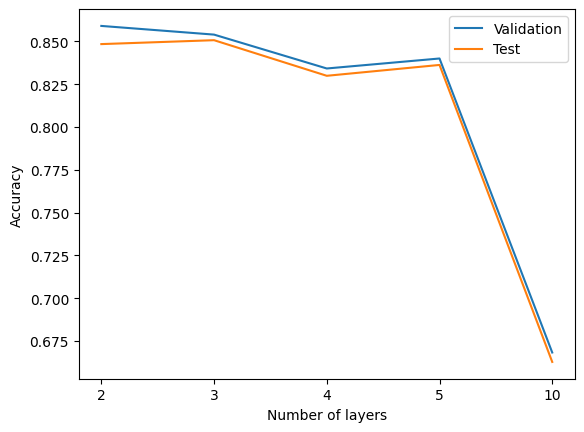

acc val: [0.8589906162820188, 0.8539183362921633, 0.8341364443317271, 0.8399695663200608, 0.6682728886634542]
acc test: [0.8483772819472617, 0.8506592292089249, 0.829868154158215, 0.8362068965517241, 0.6627789046653144]


In [15]:
hid_dim = 512
epochs = 500
lr = 0.001
n_layers_search = [2, 3, 4, 5, 10]

acc_val_list = []
acc_test_list = []
data_pubmed = data_pubmed.cuda()
for n_layers in n_layers_search:
    set_seed(0)
    model = GCN(data_pubmed.x.shape[1], hid_dim, data_pubmed.num_classes, num_layers=n_layers)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model = model.cuda()
    print(f'Number of layers: {n_layers}')
    acc_dict = train_and_eval_once(model, data_pubmed, optimizer, nn.CrossEntropyLoss(), epochs=epochs, mute=True)
    acc_val_list.append(acc_dict['val'])
    acc_test_list.append(acc_dict['test'])

# plot
plt.plot([str(d) for d in n_layers_search], acc_val_list, label='Validation')
plt.plot([str(d) for d in n_layers_search], acc_test_list, label='Test')
plt.xlabel('Number of layers')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

print(f"acc val: {acc_val_list}")
print(f"acc test: {acc_test_list}")

## T5

In [14]:
del model_text
torch.cuda.empty_cache()

In [15]:
from transformers import AutoTokenizer, T5EncoderModel
tokenizer = AutoTokenizer.from_pretrained("google-t5/t5-small")
model_text = T5EncoderModel.from_pretrained("google-t5/t5-small")
model_text = model_text.cuda()
model_text.eval()

T5EncoderModel(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=512, bias=False)
              (k): Linear(in_features=512, out_features=512, bias=False)
              (v): Linear(in_features=512, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=512, out_features=2048, bias=False)
              (wo): Linear(in_features=2048, out_features=512, bias=False)
              (dropout): Dropout(p=0.1, i

In [16]:
input_1 = "hi i am dumb."
input_2 = "i am dumb."

inputs = tokenizer(input_1, return_tensors='pt', max_length=1024, truncation=True)
inputs.to('cuda')
outputs = model_text(**inputs)
last_hidden_state = outputs.last_hidden_state           # [bs, T, 512]
embed_1 = last_hidden_state.mean(dim=1)      # [bs, 512]         # mean pooling

inputs = tokenizer(input_2, return_tensors='pt', max_length=1024, truncation=True)
inputs.to('cuda')
outputs = model_text(**inputs)
last_hidden_state = outputs.last_hidden_state           # [bs, T, 512]
embed_2 = last_hidden_state.mean(dim=1)      # [bs, 512]         # mean pooling

cos_sim = F.cosine_similarity(embed_1, embed_2, dim=1)
print(cos_sim.item())

0.9092659950256348


### Cora

In [17]:
# get text embeddings for all nodes
node_text_embed = torch.zeros(data_cora.num_nodes, 512)         # [N, 768]

bs = 256
n_nodes = data_cora.num_nodes

with torch.no_grad():
    for i in tqdm(range(0, n_nodes, bs)):
        text_inputs = tokenizer(text_cora[i:i+bs], max_length=1024, truncation=True, padding="longest", return_tensors='pt')
        text_inputs.to('cuda')
        outputs = model_text(**text_inputs)
        last_hidden_state = outputs.last_hidden_state                      # [bs, 512, 768]
        node_text_embed[i:i+bs] = last_hidden_state.mean(dim=1).to('cpu')       # [bs, 512]         # mean pooling
        

100%|██████████| 11/11 [00:15<00:00,  1.42s/it]


In [18]:
# replace node features with text embeddings
data_cora.x = node_text_embed

In [19]:
EPOCHS = 500
param_grid = {                      # 120 sets in total
    'lr': [1e-4, 1e-3, 0.01, 0.1],
    'hid_dim': [16, 32, 64, 128, 256, 512],
    'n_layers': [2, 3, 4, 5, 10]
}
param_comb = list(ParameterGrid(param_grid))
val_acc_best = 0.

data_cora = data_cora.cuda()
for c in param_comb:
    set_seed(0)
    lr = c['lr']
    hid_dim = c['hid_dim']
    n_layers = c['n_layers']

    model_gnn = GCN(data_cora.x.shape[1], hid_dim, data_cora.num_classes, num_layers=n_layers)
    optimizer = torch.optim.Adam(model_gnn.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    model_gnn = model_gnn.cuda()

    acc_dict = train_and_eval_once(model_gnn, data_cora, optimizer, criterion, epochs=EPOCHS, mute=True)
    if acc_dict['val'] > val_acc_best:
        val_acc_best = acc_dict['val']
        best_param = c
        train_acc_best = acc_dict['train']
        test_acc_best = acc_dict['test']

print(f'Best param: {best_param}, Best Val Acc: {val_acc_best*100:.2f}%')
print(f'With: Train Acc: {train_acc_best*100:.2f}%, Test Acc: {test_acc_best*100:.2f}%')

 18%|█▊        | 88/500 [00:00<00:01, 383.51it/s]


Early stopping at epoch 89


 15%|█▍        | 73/500 [00:00<00:01, 361.32it/s]


Early stopping at epoch 74


 14%|█▍        | 71/500 [00:00<00:01, 218.01it/s]


Early stopping at epoch 72


 10%|█         | 50/500 [00:00<00:03, 144.64it/s]


Early stopping at epoch 51


 16%|█▌        | 81/500 [00:00<00:03, 119.35it/s]


Early stopping at epoch 82


 11%|█         | 54/500 [00:00<00:00, 450.06it/s]


Early stopping at epoch 55


 14%|█▍        | 70/500 [00:00<00:01, 352.89it/s]


Early stopping at epoch 71


 10%|█         | 52/500 [00:00<00:01, 293.84it/s]


Early stopping at epoch 53


 11%|█▏        | 57/500 [00:00<00:01, 251.47it/s]


Early stopping at epoch 58


 10%|█         | 52/500 [00:00<00:03, 128.66it/s]


Early stopping at epoch 53


 11%|█         | 54/500 [00:00<00:01, 280.56it/s]


Early stopping at epoch 55


 75%|███████▌  | 375/500 [00:02<00:00, 179.91it/s]


Early stopping at epoch 376


 94%|█████████▎| 468/500 [00:03<00:00, 133.62it/s]


Early stopping at epoch 469


 10%|█         | 51/500 [00:00<00:07, 64.04it/s]


Early stopping at epoch 52


 10%|█         | 50/500 [00:00<00:01, 257.33it/s]


Early stopping at epoch 51


 10%|█         | 50/500 [00:00<00:01, 241.46it/s]


Early stopping at epoch 51


 10%|█         | 50/500 [00:00<00:02, 211.56it/s]


Early stopping at epoch 51


 10%|█         | 50/500 [00:00<00:03, 147.76it/s]


Early stopping at epoch 51


 10%|█         | 50/500 [00:00<00:06, 73.01it/s]


Early stopping at epoch 51


 17%|█▋        | 84/500 [00:00<00:01, 259.76it/s]


Early stopping at epoch 85


 16%|█▌        | 81/500 [00:00<00:02, 164.89it/s]


Early stopping at epoch 82


 15%|█▌        | 77/500 [00:00<00:02, 204.24it/s]


Early stopping at epoch 78


 13%|█▎        | 64/500 [00:00<00:03, 141.59it/s]


Early stopping at epoch 65


 10%|█         | 52/500 [00:00<00:06, 72.58it/s]


Early stopping at epoch 53


 11%|█         | 53/500 [00:00<00:01, 243.68it/s]


Early stopping at epoch 54


 11%|█         | 53/500 [00:00<00:02, 192.70it/s]


Early stopping at epoch 54


 10%|█         | 52/500 [00:00<00:02, 161.37it/s]


Early stopping at epoch 53


 10%|█         | 51/500 [00:00<00:02, 162.31it/s]


Early stopping at epoch 52


 10%|█         | 50/500 [00:00<00:05, 77.33it/s]


Early stopping at epoch 51


 62%|██████▏   | 312/500 [00:01<00:00, 244.32it/s]


Early stopping at epoch 313


 54%|█████▍    | 270/500 [00:01<00:01, 180.89it/s]


Early stopping at epoch 271


 10%|█         | 51/500 [00:00<00:03, 130.83it/s]


Early stopping at epoch 52


 10%|█         | 50/500 [00:00<00:06, 74.36it/s]


Early stopping at epoch 51


 10%|█         | 51/500 [00:00<00:01, 281.52it/s]


Early stopping at epoch 52


 10%|█         | 50/500 [00:00<00:01, 236.22it/s]


Early stopping at epoch 51


 12%|█▏        | 60/500 [00:00<00:02, 207.02it/s]


Early stopping at epoch 61


 10%|█         | 50/500 [00:00<00:03, 147.66it/s]


Early stopping at epoch 51


 10%|█         | 50/500 [00:00<00:04, 97.96it/s] 


Early stopping at epoch 51


 13%|█▎        | 66/500 [00:00<00:01, 416.17it/s]

Early stopping at epoch 67



 14%|█▍        | 69/500 [00:00<00:01, 257.53it/s]


Early stopping at epoch 70


 13%|█▎        | 67/500 [00:00<00:02, 176.71it/s]


Early stopping at epoch 68


 16%|█▌        | 78/500 [00:00<00:02, 158.89it/s]


Early stopping at epoch 79


 15%|█▌        | 77/500 [00:01<00:05, 75.62it/s] 


Early stopping at epoch 78


 10%|█         | 51/500 [00:00<00:01, 295.78it/s]


Early stopping at epoch 52


 11%|█         | 53/500 [00:00<00:01, 253.65it/s]


Early stopping at epoch 54


 10%|█         | 52/500 [00:00<00:05, 85.53it/s] 


Early stopping at epoch 53


 66%|██████▌   | 331/500 [00:01<00:00, 284.55it/s]


Early stopping at epoch 332


 62%|██████▏   | 309/500 [00:00<00:00, 366.26it/s]


Early stopping at epoch 310


 54%|█████▍    | 270/500 [00:01<00:01, 175.20it/s]


Early stopping at epoch 271


 65%|██████▍   | 324/500 [00:02<00:01, 138.15it/s]


Early stopping at epoch 325


 10%|█         | 50/500 [00:00<00:06, 73.44it/s]


Early stopping at epoch 51


 10%|█         | 50/500 [00:00<00:01, 244.52it/s]


Early stopping at epoch 51


 10%|█         | 50/500 [00:00<00:02, 203.05it/s]


Early stopping at epoch 51


 10%|█         | 50/500 [00:00<00:02, 155.48it/s]


Early stopping at epoch 51


 10%|█         | 50/500 [00:00<00:03, 127.00it/s]


Early stopping at epoch 51


 10%|█         | 50/500 [00:00<00:04, 95.26it/s] 


Early stopping at epoch 51


 13%|█▎        | 65/500 [00:00<00:01, 272.49it/s]


Early stopping at epoch 66


 11%|█         | 53/500 [00:00<00:02, 195.41it/s]


Early stopping at epoch 54


 12%|█▏        | 60/500 [00:00<00:02, 154.05it/s]


Early stopping at epoch 61


 11%|█         | 55/500 [00:00<00:03, 132.00it/s]


Early stopping at epoch 56


 12%|█▏        | 61/500 [00:00<00:05, 83.99it/s]


Early stopping at epoch 62


 95%|█████████▍| 473/500 [00:02<00:00, 184.38it/s]


Early stopping at epoch 474


 84%|████████▍ | 422/500 [00:02<00:00, 171.51it/s]


Early stopping at epoch 423


 90%|████████▉ | 449/500 [00:03<00:00, 148.82it/s]


Early stopping at epoch 450


 10%|█         | 51/500 [00:00<00:05, 89.57it/s] 


Early stopping at epoch 52


 54%|█████▎    | 268/500 [00:01<00:00, 253.62it/s]


Early stopping at epoch 269


 71%|███████   | 353/500 [00:01<00:00, 253.63it/s]


Early stopping at epoch 354


 78%|███████▊  | 388/500 [00:02<00:00, 177.82it/s]


Early stopping at epoch 389


 13%|█▎        | 67/500 [00:00<00:05, 74.25it/s]


Early stopping at epoch 68


 10%|█         | 50/500 [00:00<00:01, 268.87it/s]


Early stopping at epoch 51


 13%|█▎        | 67/500 [00:00<00:01, 242.05it/s]


Early stopping at epoch 68


 10%|█         | 50/500 [00:00<00:02, 182.25it/s]


Early stopping at epoch 51


 10%|█         | 50/500 [00:00<00:03, 140.81it/s]


Early stopping at epoch 51


 13%|█▎        | 64/500 [00:00<00:06, 71.87it/s]


Early stopping at epoch 65


 11%|█         | 53/500 [00:00<00:01, 282.92it/s]


Early stopping at epoch 54


 11%|█         | 55/500 [00:00<00:01, 288.13it/s]


Early stopping at epoch 56


 11%|█         | 56/500 [00:00<00:02, 185.74it/s]


Early stopping at epoch 57


 10%|█         | 50/500 [00:00<00:02, 162.59it/s]


Early stopping at epoch 51


 10%|█         | 50/500 [00:00<00:06, 71.97it/s]


Early stopping at epoch 51


 67%|██████▋   | 337/500 [00:01<00:00, 178.02it/s]


Early stopping at epoch 338


 70%|███████   | 352/500 [00:02<00:00, 164.90it/s]


Early stopping at epoch 353


 80%|████████  | 402/500 [00:03<00:00, 133.61it/s]


Early stopping at epoch 403


 10%|█         | 50/500 [00:00<00:05, 85.01it/s]


Early stopping at epoch 51


 65%|██████▌   | 326/500 [00:01<00:00, 251.13it/s]


Early stopping at epoch 327


 70%|███████   | 350/500 [00:01<00:00, 215.74it/s]


Early stopping at epoch 351


 39%|███▉      | 196/500 [00:01<00:02, 147.22it/s]


Early stopping at epoch 197


 10%|█         | 50/500 [00:00<00:06, 69.49it/s]


Early stopping at epoch 51


 10%|█         | 50/500 [00:00<00:01, 252.06it/s]


Early stopping at epoch 51


 10%|█         | 50/500 [00:00<00:02, 190.55it/s]


Early stopping at epoch 51


 10%|█         | 50/500 [00:00<00:02, 153.48it/s]


Early stopping at epoch 51


 10%|█         | 50/500 [00:00<00:02, 179.67it/s]


Early stopping at epoch 51


 13%|█▎        | 66/500 [00:00<00:05, 74.60it/s]


Early stopping at epoch 67


 10%|█         | 51/500 [00:00<00:01, 252.50it/s]


Early stopping at epoch 52


 10%|█         | 52/500 [00:00<00:02, 197.19it/s]


Early stopping at epoch 53


 10%|█         | 50/500 [00:00<00:02, 155.27it/s]


Early stopping at epoch 51


 10%|█         | 52/500 [00:00<00:03, 129.27it/s]


Early stopping at epoch 53


 10%|█         | 50/500 [00:00<00:06, 66.75it/s]


Early stopping at epoch 51


 78%|███████▊  | 391/500 [00:01<00:00, 244.20it/s]


Early stopping at epoch 392


 57%|█████▋    | 286/500 [00:01<00:01, 204.76it/s]


Early stopping at epoch 287


 64%|██████▍   | 320/500 [00:02<00:01, 152.99it/s]


Early stopping at epoch 321


 66%|██████▋   | 332/500 [00:02<00:01, 131.21it/s]


Early stopping at epoch 333


 10%|█         | 50/500 [00:00<00:06, 66.30it/s]


Early stopping at epoch 51


 63%|██████▎   | 316/500 [00:01<00:00, 267.04it/s]


Early stopping at epoch 317


 56%|█████▌    | 281/500 [00:01<00:01, 185.42it/s]


Early stopping at epoch 282


 74%|███████▍  | 370/500 [00:02<00:00, 151.57it/s]


Early stopping at epoch 371


 10%|█         | 50/500 [00:00<00:06, 67.59it/s]


Early stopping at epoch 51


 10%|█         | 50/500 [00:00<00:01, 253.77it/s]


Early stopping at epoch 51


 10%|█         | 50/500 [00:00<00:02, 209.28it/s]


Early stopping at epoch 51


 10%|█         | 50/500 [00:00<00:02, 170.55it/s]


Early stopping at epoch 51


 10%|█         | 50/500 [00:00<00:03, 130.86it/s]


Early stopping at epoch 51


 10%|█         | 50/500 [00:00<00:06, 67.38it/s]


Early stopping at epoch 51
Best param: {'hid_dim': 512, 'lr': 0.001, 'n_layers': 4}, Best Val Acc: 85.06%
With: Train Acc: 90.70%, Test Acc: 87.08%


### Pubmed

In [20]:
# get text embeddings for all nodes
node_text_embed = torch.zeros(data_pubmed.num_nodes, 512)         # [N, 512]

bs = 128
n_nodes = data_pubmed.num_nodes

with torch.no_grad():
    for i in tqdm(range(0, n_nodes, bs)):
        text_inputs = tokenizer(text_pubmed[i:i+bs], max_length=1024, truncation=True, padding="longest", return_tensors='pt')
        text_inputs.to('cuda')
        outputs = model_text(**text_inputs)
        last_hidden_state = outputs.last_hidden_state                      # [bs, 512, 768]
        node_text_embed[i:i+bs] = last_hidden_state.mean(dim=1).to('cpu')       # [bs, 512]         # mean pooling
        

100%|██████████| 155/155 [01:59<00:00,  1.29it/s]


In [21]:
data_pubmed.x = node_text_embed

In [22]:
EPOCHS = 500
param_grid = {                      # 120 sets in total
    'lr': [1e-4, 1e-3, 0.01, 0.1],
    'hid_dim': [16, 32, 64, 128, 256, 512],
    'n_layers': [2, 3, 4, 5, 10]
}
param_comb = list(ParameterGrid(param_grid))
val_acc_best = 0.

data_pubmed = data_pubmed.cuda()
for c in param_comb:
    set_seed(0)
    lr = c['lr']
    hid_dim = c['hid_dim']
    n_layers = c['n_layers']

    model_gnn = GCN(data_pubmed.x.shape[1], hid_dim, data_pubmed.num_classes, num_layers=n_layers)
    optimizer = torch.optim.Adam(model_gnn.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    model_gnn = model_gnn.cuda()

    acc_dict = train_and_eval_once(model_gnn, data_pubmed, optimizer, criterion, epochs=EPOCHS, mute=True)
    if acc_dict['val'] > val_acc_best:
        val_acc_best = acc_dict['val']
        best_param = c
        train_acc_best = acc_dict['train']
        test_acc_best = acc_dict['test']

print(f'Best param: {best_param}, Best Val Acc: {val_acc_best*100:.2f}%')
print(f'With: Train Acc: {train_acc_best*100:.2f}%, Test Acc: {test_acc_best*100:.2f}%')

 10%|█         | 50/500 [00:00<00:01, 307.81it/s]


Early stopping at epoch 51


 10%|█         | 50/500 [00:00<00:02, 213.94it/s]


Early stopping at epoch 51


 13%|█▎        | 65/500 [00:00<00:02, 178.65it/s]


Early stopping at epoch 66


 15%|█▍        | 74/500 [00:00<00:03, 138.19it/s]


Early stopping at epoch 75


 20%|██        | 100/500 [00:01<00:05, 78.70it/s]


Early stopping at epoch 101


 10%|█         | 52/500 [00:00<00:06, 74.08it/s]


Early stopping at epoch 53


 71%|███████   | 353/500 [00:01<00:00, 266.69it/s]


Early stopping at epoch 354


 74%|███████▍  | 370/500 [00:02<00:00, 179.33it/s]


Early stopping at epoch 371


 58%|█████▊    | 291/500 [00:02<00:01, 129.22it/s]


Early stopping at epoch 292


 89%|████████▉ | 444/500 [00:05<00:00, 74.75it/s]


Early stopping at epoch 445


 34%|███▍      | 170/500 [00:00<00:00, 388.27it/s]


Early stopping at epoch 171


 10%|█         | 50/500 [00:00<00:01, 323.88it/s]

Early stopping at epoch 51



 10%|█         | 50/500 [00:00<00:01, 277.35it/s]


Early stopping at epoch 51


 10%|█         | 51/500 [00:00<00:02, 176.24it/s]


Early stopping at epoch 52


 10%|█         | 51/500 [00:00<00:05, 80.82it/s] 


Early stopping at epoch 52


 23%|██▎       | 117/500 [00:00<00:01, 240.74it/s]


Early stopping at epoch 118


 13%|█▎        | 64/500 [00:00<00:02, 171.08it/s]


Early stopping at epoch 65


 10%|█         | 50/500 [00:00<00:03, 142.52it/s]


Early stopping at epoch 51


 10%|█         | 50/500 [00:00<00:05, 86.44it/s]


Early stopping at epoch 51


 99%|█████████▊| 493/500 [00:06<00:00, 76.21it/s] 


Early stopping at epoch 494


 90%|█████████ | 450/500 [00:01<00:00, 250.03it/s]


Early stopping at epoch 451


 79%|███████▉  | 397/500 [00:01<00:00, 227.75it/s]


Early stopping at epoch 398


 75%|███████▍  | 374/500 [00:02<00:00, 167.06it/s]


Early stopping at epoch 375


 82%|████████▏ | 412/500 [00:03<00:00, 129.35it/s]


Early stopping at epoch 413


 91%|█████████▏| 457/500 [00:06<00:00, 70.94it/s]


Early stopping at epoch 458


 69%|██████▉   | 345/500 [00:01<00:00, 245.23it/s]


Early stopping at epoch 346


 25%|██▍       | 124/500 [00:00<00:02, 168.79it/s]


Early stopping at epoch 125


 11%|█         | 55/500 [00:00<00:03, 140.16it/s]


Early stopping at epoch 56


 21%|██        | 105/500 [00:00<00:02, 135.42it/s]


Early stopping at epoch 106


 11%|█         | 55/500 [00:00<00:06, 68.78it/s]


Early stopping at epoch 56


 29%|██▉       | 145/500 [00:01<00:02, 140.39it/s]


Early stopping at epoch 146


 10%|█         | 52/500 [00:00<00:03, 120.83it/s]


Early stopping at epoch 53


 11%|█         | 55/500 [00:00<00:05, 74.96it/s]


Early stopping at epoch 56


 37%|███▋      | 183/500 [00:01<00:02, 122.14it/s]


Early stopping at epoch 184


 96%|█████████▌| 480/500 [00:06<00:00, 73.75it/s]


Early stopping at epoch 481


 71%|███████   | 354/500 [00:01<00:00, 185.86it/s]


Early stopping at epoch 355


 46%|████▌     | 231/500 [00:01<00:01, 194.68it/s]


Early stopping at epoch 232


 59%|█████▉    | 296/500 [00:02<00:01, 129.36it/s]


Early stopping at epoch 297


 22%|██▏       | 111/500 [00:00<00:01, 322.94it/s]


Early stopping at epoch 112


 10%|█         | 50/500 [00:00<00:01, 271.12it/s]


Early stopping at epoch 51


 12%|█▏        | 58/500 [00:00<00:01, 225.05it/s]


Early stopping at epoch 59


 10%|█         | 51/500 [00:00<00:02, 183.25it/s]


Early stopping at epoch 52


 12%|█▏        | 58/500 [00:00<00:04, 94.94it/s]


Early stopping at epoch 59


 17%|█▋        | 86/500 [00:01<00:08, 47.80it/s]


Early stopping at epoch 87


 85%|████████▍ | 424/500 [00:08<00:01, 48.50it/s]


Early stopping at epoch 425


 64%|██████▎   | 318/500 [00:01<00:01, 163.53it/s]


Early stopping at epoch 319


 58%|█████▊    | 290/500 [00:02<00:01, 124.20it/s]


Early stopping at epoch 291


 62%|██████▏   | 308/500 [00:06<00:03, 48.19it/s]


Early stopping at epoch 309


 50%|█████     | 251/500 [00:01<00:01, 245.72it/s]


Early stopping at epoch 252


 45%|████▍     | 223/500 [00:01<00:01, 165.89it/s]


Early stopping at epoch 224


 30%|██▉       | 148/500 [00:01<00:02, 123.50it/s]


Early stopping at epoch 149


 15%|█▌        | 76/500 [00:00<00:04, 96.00it/s]


Early stopping at epoch 77


 10%|█         | 51/500 [00:01<00:09, 48.18it/s]


Early stopping at epoch 52


 10%|█         | 50/500 [00:02<00:18, 24.01it/s]


Early stopping at epoch 51


 83%|████████▎ | 415/500 [00:08<00:01, 51.65it/s]


Early stopping at epoch 416


 56%|█████▌    | 280/500 [00:11<00:09, 24.34it/s]


Early stopping at epoch 281


 71%|███████   | 354/500 [00:02<00:00, 167.86it/s]


Early stopping at epoch 355


 62%|██████▏   | 310/500 [00:03<00:02, 92.93it/s]


Early stopping at epoch 311


 59%|█████▉    | 295/500 [00:04<00:03, 66.20it/s]


Early stopping at epoch 296


 73%|███████▎  | 363/500 [00:06<00:02, 52.01it/s]


Early stopping at epoch 364


 96%|█████████▌| 481/500 [00:19<00:00, 24.55it/s]


Early stopping at epoch 482


 22%|██▏       | 111/500 [00:00<00:02, 162.14it/s]


Early stopping at epoch 112


 10%|█         | 51/500 [00:00<00:04, 91.11it/s]


Early stopping at epoch 52


 10%|█         | 51/500 [00:00<00:06, 65.69it/s]


Early stopping at epoch 52


 13%|█▎        | 66/500 [00:01<00:08, 51.19it/s]


Early stopping at epoch 67


 10%|█         | 51/500 [00:02<00:18, 24.04it/s]


Early stopping at epoch 52


 11%|█▏        | 57/500 [00:00<00:05, 87.50it/s]


Early stopping at epoch 58


 44%|████▍     | 220/500 [00:19<00:24, 11.21it/s]


Early stopping at epoch 221


 66%|██████▌   | 329/500 [00:10<00:05, 32.64it/s]


Early stopping at epoch 330


 84%|████████▎ | 418/500 [00:16<00:03, 25.00it/s]


Early stopping at epoch 419


 26%|██▌       | 128/500 [00:11<00:33, 11.25it/s]


Early stopping at epoch 129


 89%|████████▉ | 446/500 [00:04<00:00, 91.01it/s]


Early stopping at epoch 447


 85%|████████▌ | 427/500 [00:08<00:01, 48.21it/s]


Early stopping at epoch 428


 57%|█████▋    | 283/500 [00:08<00:06, 33.06it/s]


Early stopping at epoch 284


 59%|█████▉    | 296/500 [00:11<00:08, 25.03it/s]


Early stopping at epoch 297


 28%|██▊       | 138/500 [00:12<00:32, 11.29it/s]


Early stopping at epoch 139


 50%|████▉     | 248/500 [00:02<00:02, 91.35it/s]


Early stopping at epoch 249


 10%|█         | 51/500 [00:01<00:13, 32.42it/s]


Early stopping at epoch 52


 10%|█         | 51/500 [00:02<00:18, 24.45it/s]


Early stopping at epoch 52


 10%|█         | 51/500 [00:04<00:40, 11.17it/s]


Early stopping at epoch 52
Best param: {'hid_dim': 128, 'lr': 0.01, 'n_layers': 2}, Best Val Acc: 85.54%
With: Train Acc: 87.23%, Test Acc: 85.12%


In [23]:
del model_text          # release memory occupied by the LM model
torch.cuda.empty_cache()